# Lab 17: VEGAS Tutorial

In this lab, we will learn how to use the VEGAS algorithm to estimate the integral of a function. VEGAS is a Monte Carlo algorithm that uses importance sampling to estimate the integral of a function. The algorithm is particularly useful for high-dimensional integrals, where traditional methods such as the trapezoidal rule or Simpson's rule become impractical.

We will attempt to produce 100,000 events of the following function composed of two Gaussian distributions:

$$f(x, y) = A_1 \exp\left [-\frac{1}{2} \left ( \frac{(x - \mu_{1x})^2}{\sigma_{1x}^2} + \frac{(y - \mu_{1y})^2}{\sigma_{1y}^2} \right ) \right] + A_2 \exp\left [-\frac{1}{2} \left ( \frac{(x - \mu_{2x})^2}{\sigma_{2x}^2} + \frac{(y - \mu_{2y})^2}{\sigma_{2y}^2} \right ) \right]$$

over the range $0 < x, y < 5$. We will use the following parameters for the function:
$$A_1 = 1.0, \quad\mu_{1x} = 2.5, \quad\sigma_{1x} = 1.0, \quad\mu_{1y} = 2.5, \quad\sigma_{1y} = 1.0$$
$$A_2 = 4.0, \quad\mu_{2x} = 2.5, \quad\sigma_{2x} = 0.1, \quad\mu_{2y} = 2.5, \quad\sigma_{2y} = 0.1$$

References:
1. T. Barklow, "Monte Carlo Techniques", https://courses.physics.illinois.edu/phys524/fa2023/topics.html (2023).
2. G. P. Lepage, "A New Algorithm for Adaptive Multidimensional Integration", J. Comput. Phys. 27, 192 (1978).
3. G. P. Lepage, "Adaptive multidimensional integration: VEGAS enhanced", J. Comput. Phys. 439, 110386 (2021).

In [1]:
# import the required libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import matplotlib.cm as mpl

In [2]:
# Define Parameters

# Gaussian not offset - Parameters for two Gaussian distributions used in the integral estimation.

# Amplitudes for the Gaussians. A1 is for the first Gaussian, and A2 is for the second.
# Higher amplitude (A2) indicates a peak that is more pronounced relative to the first Gaussian.
A1 = 1.0
A2 = 4.0

# Mean values (MU) along the x-axis for both Gaussians. Both are centered at the same point (2.5),
# indicating that the Gaussians are aligned along the x-axis without any horizontal displacement.
MU1X = 2.5
MU2X = 2.5

# Standard deviations (SIGMA) along the x-axis for both Gaussians. SIGMA1X represents a wider spread
# for the first Gaussian, while SIGMA2X indicates a much narrower spread for the second Gaussian.
SIGMA1X = 1.0
SIGMA2X = 0.1

# Mean values (MU) along the y-axis for both Gaussians. Similar to the x-axis, both Gaussians are centered
# at the same point (2.5) along the y-axis, indicating no vertical displacement between them.
MU1Y = 2.5
MU2Y = 2.5

# Standard deviations (SIGMA) along the y-axis for both Gaussians. SIGMA1Y is for the first Gaussian,
# showing a wider spread, and SIGMA2Y for the second, showing a narrower spread, consistent with their x-axis counterparts.
SIGMA1Y = 1.0
SIGMA2Y = 0.1

# Integration bounds for the VEGAS algorithm. Specifies the area over which the integral is to be estimated.
# These bounds are the same for both the x and y dimensions, from 0 to 5, covering the area of interest.
XMIN = 0.0
YMIN = 0.0
XMAX = 5.0
YMAX = 5.0

# # Offset the gaussians
# A1 = 1.0
# A2 = 1.0
# MU1X = 2.5
# MU2X = 2.5
# SIGMA1X = 1.0
# SIGMA2X = 1.0
# MU1Y = -2.5
# MU2Y = -2.5
# SIGMA1Y = 1.0
# SIGMA2Y = 1.0

# XMIN = -5.0
# YMIN = -5.0
# XMAX = 5.0
# YMAX = 5.0

def f(yy1, yy2):
    # Calculate the exponent for the first Gaussian distribution using the input coordinates (yy1, yy2)
    # and parameters defined previously (MU1X, MU1Y, SIGMA1X, SIGMA1Y).
    # The exponent calculation incorporates the Gaussian formula for two dimensions.
    exponent1 = -0.5 * (
        ((yy1 - MU1X) ** 2) / (2 * SIGMA1X**2)
        + ((yy2 - MU1Y) ** 2) / (2 * SIGMA1Y**2)
    )

    # Calculate the exponent for the second Gaussian distribution using similar methodology as above,
    # but with the second set of parameters (MU2X, MU2Y, SIGMA2X, SIGMA2Y).
    exponent2 = -0.5 * (
        ((yy1 - MU2X) ** 2) / (2 * SIGMA2X**2)
        + ((yy2 - MU2Y) ** 2) / (2 * SIGMA2Y**2)
    )

    # Calculate the overall result by combining the contributions from both Gaussian distributions.
    # This is done by scaling each Gaussian by its amplitude (A1, A2) and summing them.
    # np.exp is used to compute the exponential function e^x for each exponent.
    result = A1 * np.exp(exponent1) + A2 * np.exp(exponent2)
    return result

# Calculate the maximum value of the function f at the point (MU1X, MU1Y).
# This point corresponds to the center of the first Gaussian distribution,
# where the function is likely to have a significant value due to the amplitude and spread of the Gaussian.
F_VAL_MAX = f(MU1X, MU1Y)


This lego plot will show the function we are trying to integrate.

In [3]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    # Convert input lists of x and y amplitudes into numpy arrays for compatibility with matplotlib.
    x = np.array(xAmplitudes)
    y = np.array(yAmplitudes)

    # Initialize a figure object to create a canvas and specify the plot as 3D.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Compute a 2D histogram from the x and y inputs. 'bins' defines the resolution of the histogram.
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))

    # Generate grid coordinates for the histogram bins.
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])
    xpos = xpos.flatten() / 2.0  # Center x-position of the bars.
    ypos = ypos.flatten() / 2.0  # Center y-position of the bars.
    zpos = np.zeros_like(xpos)  # Base z-position of the bars.

    # Calculate the width (dx, dy) and height (dz) of each bar.
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()  # Bar heights determined by the histogram.

    # Choose the color map and normalize the bar heights for coloring.
    cmap = mpl.cm.jet  # Use the 'jet' colormap.
    max_height = np.max(dz)  # Find the maximum bar height for normalization.
    min_height = np.min(dz)  # Find the minimum bar height for normalization.
    rgba = [cmap((k - min_height) / max_height) for k in dz]  # Map each bar's height to a color.

    # Create 3D bars with the computed properties and color them based on their height.
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")

    # Set plot labels and title.
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

    # Set the x and y limits of the plot to the predefined ranges.
    plt.xlim(XMIN, XMAX)
    plt.ylim(YMIN, YMAX)

    # Display the plot.
    plt.show()

## Acceptance-rejection Method
Now, we define the standard acceptance-rejection method.

In [4]:
def brute_force(nPoints, seed=None):
    # Initialize variables:
    # nFunctionEval: counts the number of function evaluations
    # yy1_rej_method, yy2_rej_method: store accepted points
    # maxWeightEncounteredRej: tracks the maximum weight encountered during rejection
    nFunctionEval = 0
    yy1_rej_method = []
    yy2_rej_method = []
    maxWeightEncounteredRej = -1.0e20  # Start with a very small value

    # Initialize a random number generator with an optional seed for reproducibility.
    generator = np.random.RandomState(seed=seed)

    # Continue sampling until the desired number of points (nPoints) is reached.
    while len(yy1_rej_method) < nPoints:
        # Generate random numbers: rr[0] and rr[1] are used for the coordinates,
        # rr[2] is used for the acceptance-rejection condition.
        rr = generator.uniform(size=3)
        
        # Calculate the coordinates (yy1, yy2) within the specified range [XMIN, XMAX] and [YMIN, YMAX].
        yy1, yy2 = XMIN + rr[0] * (XMAX - XMIN), YMIN + rr[1] * (YMAX - YMIN)
        
        # Increment function evaluation counter.
        nFunctionEval += 1

        # Evaluate the function f at the generated point (yy1, yy2).
        f_val = f(yy1, yy2)

        # Update maxWeightEncounteredRej if the current function value exceeds the previously recorded maximum.
        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val

        # Check if the current function value exceeds a predefined maximum (F_VAL_MAX),
        # if so, print an error message and exit the program.
        if f_val > F_VAL_MAX:
            print(f" f_val={f_val} exceeds F_VAL_MAX={F_VAL_MAX}, program will now exit")
            exit(99)

        # Implement the acceptance-rejection criterion: accept the point if f_val / F_VAL_MAX > rr[2].
        # This compares the normalized function value at the point against a random threshold.
        if f_val / F_VAL_MAX > rr[2]:
            yy1_rej_method.append(yy1)  # Append the x-coordinate to the accepted points list.
            yy2_rej_method.append(yy2)  # Append the y-coordinate to the accepted points list.

    # Return a dictionary containing the accepted points, number of function evaluations,
    # and the maximum weight encountered.
    return {
        "yy1": yy1_rej_method,
        "yy2": yy2_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
    }

## Vegas Method

In [5]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    xLow = XMIN + (XMAX - XMIN) / NN * np.arange(NN + 1)
    delx = np.ones(NN) * (XMAX - XMIN) / NN
    px = np.ones(NN) / (XMAX - XMIN)  # probability density in each interval
    yLow = YMIN + YMAX / NN * np.arange(NN + 1)
    dely = np.ones(NN) * (YMAX - YMIN) / NN
    py = np.ones(NN) / (YMAX - YMIN)

    # two phases to the vegas alg - first phase is determining the grid in the x-y plane
    # end up with smaller bins if prob is larger, larger bins if prob is lower
    
    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK) # indexing a np array by another np array - picks out the elements of the np array that are in those indices
        # if ixLow was
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = f(xx, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum
        # mm to subdivide into smaller bins (added)
        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)
        # recombine them after the subdivision
        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]
        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely


def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + delx[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = f(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

In [6]:
# example - sample from the respective index from 

a = np.array([1,2,3])
b = np.array([0,1,1])

a[b]

array([1, 2, 2])

Run both algorithms and compare results

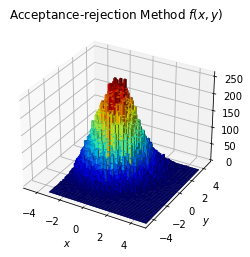

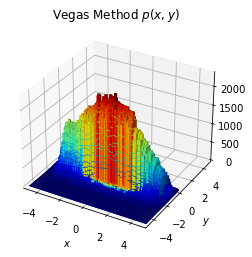

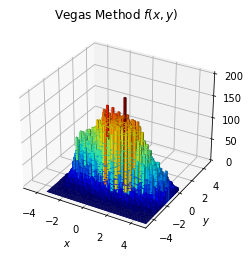

Acceptance-rejection method nPoints=100000, nFunctionEval=862406, maxWeightEncounteredRej=1.9999879717425808, F_VAL_MAX=2.0
Vegas method nPoints=100000, nFunctionEval=1165160, maxWeightEncountered=245.01393030280977, vegasRatioMax=268.253375631876, vegasRatioFactor=1


In [11]:
def plot_results(
    nPoints,
    vegasRatioFactor,
    nBins=50,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    bf = brute_force(nPoints, seed)
    vg = vegas(nPoints, vegasRatioFactor, NN, KK, nIterations, alpha_damp, seed)
    # brute force
    titleRej = r"Acceptance-rejection Method $f(x,y)$"
    lego_plot(bf["yy1"], bf["yy2"], nBins, "$x$", "$y$", titleRej)
    plt.show()

    # Vegas method
    titleVrho = r"Vegas Method $p(x,y)$"
    lego_plot(vg["yy1vrho"], vg["yy2vrho"], nBins, "$x$", "$y$", titleVrho)
    plt.show()

    titleVegas = r"Vegas Method $f(x,y)$"
    lego_plot(vg["yy1vegas"], vg["yy2vegas"], nBins, "$x$", "$y$", titleVegas)
    plt.show()

    print(
        f"Acceptance-rejection method nPoints={nPoints}, nFunctionEval={bf['nFunEval']}, maxWeightEncounteredRej={bf['maxWeightEncountered']}, F_VAL_MAX={F_VAL_MAX}"
    )
    print(
        f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
    )


plot_results(100_000, 1) # changed 0.1 to 0.5 (vegas ratio factor)
# vegas ratio factor is the ratio of the function youre trying to evaluate divided by the prob dist

In [8]:
# our sampling is pretty efficient - for the vegas method, needed a factor of 2 fewer function evaluations
# to get a similar result

In [ ]:
# two failure modes for the vegas ratio factor - if too low, wont converge, due to the errors
# if too high, may take a lot longer (sampling in regions you dont need to sample)
# want to find the smallest value, such that you dont find any errors

## Exercises
1. Try without the `alpha_damp` parameter, i.e.
```python
# mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
mmx = KK * logArgx
mmx = mmx.astype(int)
mmx = np.where(mmx > 1, mmx, 1)
# mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
mmy = KK * logArgy
mmy = mmy.astype(int)
mmy = np.where(mmy > 1, mmy, 1)
```
2. Change the form of the Gaussians to be offset from one another, e.g.
```python
A1 = 1.0
A2 = 1.0
MU1X = 2.5
MU2X = 2.5
SIGMA1X = 1.0
SIGMA2X = 1.0
MU1Y = -2.5
MU2Y = -2.5
SIGMA1Y = 1.0
SIGMA2Y = 1.0
XMIN = -5.0
YMIN = -5.0
XMAX = 5.0
YMAX = 5.0
```
Note, you may have to change `vegasRatioFactor` to a different value.

In [ ]:
# can retry without the alpha daming factor
# this example is good for the vegas alg, bc it is a sharply peaked function
# try it with a different kind of function, like the sum of two gaussians that are offset from one another
    # the vegas alg may not do quite as well, may not improve over the vegas method

In [ ]:
# vegas ratio factor

# ratio between 
# sets the vegas ratio max in the function
# the ratio of the 
# when you define the grid, define the prob distribution, from which you will sample, step function, uniform value in each bin
# because theres fewer bins in some areas, more in others - end up with a function
# set the max value of the ratio between the function and prob distrivution function
# can calculate what this is
# know where the function max is (2.5)
# check what is the value of the function there, pxy
# tell us the vegas ratio factor
# if you dont know the function max, then could just guess
# or you can determine it analytically